In [1]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
from scipy.linalg import eig
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

import moyra as ma
import moyra.elements as ele
import moyra.forces as ef

import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo
import FwtModels as mf

me.mechanics_printing()

In [2]:
test_num = 6

b_modes = 3
t_modes = 2
kink_b_modes = 1
kink_t_modes = 1
fwt_modes = 1
modes = b_modes + t_modes + kink_t_modes + kink_b_modes + fwt_modes
main_inner_panels = 12
main_outer_panels = 8
main_panels = main_inner_panels + main_outer_panels
fwt_panels = 15
tab_panels = 10
panels = main_panels + fwt_panels

p = ma.DynamicModelParameters(modes)

## Create some global parameters
p.b_modes = ma.ModelSymbol(value = b_modes,string = 'b_modes') # percentage of wing that is a FWT
p.t_modes = ma.ModelSymbol(value = t_modes,string = 't_modes') # percentage of wing that is a FWT
p.kink_b_modes = ma.ModelSymbol(value = kink_b_modes,string = 'kink_b_modes') # percentage of wing that is a FWT
p.kink_t_modes = ma.ModelSymbol(value = kink_t_modes,string = 'kink_t_modes') # percentage of wing that is a FWT
p.modes = ma.ModelSymbol(value = modes,string = 'modes') # percentage of wing that is a FWT

p.c = ma.ModelSymbol(value = 0.15,string = 'c') # chord of wing
p.s_i = ma.ModelSymbol(value = 1,string = 's_i') # total semi-span of wing
p.s_f = ma.ModelSymbol(value = 0.345,string = 's_f') # total semi-span of wingtip
p.s_t = ma.ModelSymbol(value = 0.1,string = 's_t') # total length of the tab
p.alpha_r = ma.ModelSymbol(value = np.deg2rad(3),string = 'alpha_r') # root AoA

## inner beam section
p.s_1 = ma.ModelSymbol(value = 0.8,string = 's_1') # total length of the tab
p.c_b = ma.ModelSymbol(value = 0.03,string = 'c_b') # chord of beam
p.rho_b = ma.ModelSymbol(value = 19.53,string = 'rho_b') # beam mass per unit area (kg/m^2)

## outer beam section
p.c_b2 = ma.ModelSymbol(value = 0.02,string = 'c_b2') # chord of beam
p.rho_b2 = ma.ModelSymbol(value = 19.53,string = 'rho_b2') # beam mass per unit area (kg/m^2)
p.EI = ma.ModelSymbol(value = 9.77e6,string = 'EI') # Bending stiffness for the wing
p.GJ = ma.ModelSymbol(value = 0.99e6,string = 'GJ') # Torsional Stiffness for the wing

p.K_hinge = ma.ModelSymbol(value = 0,string = 'K_hinge')    # Unsteady Torsional Term

## wing uniform mass
p.rho_w = ma.ModelSymbol(value = 19.53,string = 'rho_w') # wing mass per unit area (kg/m^2)
p.c_w = ma.ModelSymbol(value = 0.15,string = 'c_w') # chord over which to integrate wing mass
p.EI_2 = ma.ModelSymbol(value = 9.77e6,string = 'EI_2') # Bending stiffness for the wing
p.GJ_2 = ma.ModelSymbol(value = 0.99e6,string = 'GJ_2') # Torsional Stiffness for the wing


# Location of flexural axes fro beam
p.e_0 = ma.ModelSymbol(value = 0.08,string = 'e_0')
p.x_f0 = ma.ModelSymbol(value = 0.08,string = 'x_f')

# FWT mass element
p.m_f = ma.ModelSymbol(value = 0.3,string = 'm_f')
p.x_comf = ma.ModelSymbol(value = 0.3,string = 'x_comf')
p.y_comf = ma.ModelSymbol(value = 0.3,string = 'y_comf')
p.I_xxf = ma.ModelSymbol(value = 0.3,string = 'I_xxf') # inertia of FWT (uniform bar)
p.I_yyf = ma.ModelSymbol(value = 0.3,string = 'I_yyf') # inertia of FWT (uniform bar)

# FWT properties
p.Lambda = ma.ModelSymbol(value = np.deg2rad(10),string = 'Lambda') # Flare Angle
p.mu = ma.ModelSymbol(value = 0,string = 'mu')                 # dihedral angle at the end of the inner wing
p.mu_d = ma.ModelSymbol(value = 0,string = 'mu_d') # rate of change of dihedral angle at the tip of the inner wing

# Symbols to translate along inner wing and FWT
p.y_0 =ma.ModelSymbol(value = 0,string = 'y_0')        # inner wing y chord
p.x_0 = ma.ModelSymbol(value = 0,string = 'x_0')       # inner wing x chord
p.y_1 = ma.ModelSymbol(value = 0,string = 'y_1')       # FWT y chord
p.x_1 = ma.ModelSymbol(value = 0,string = 'x_1')       # FWT x chord

# Unsteady Aero Terms
p.k = ma.ModelSymbol(value = 0,string = 'k')    # reduced frequency
p.AR = ma.ModelSymbol(value = 0,string = 'AR')    # Aspect Ratio
p.M_thetadot = ma.ModelSymbol(value = -1.2,string = 'M_thetadot')    # Unsteady Torsional Term


## Aero Parameters
p.rho = ma.ModelSymbol(value = 1.225,string = 'rho')                 # density
p.V = ma.ModelSymbol(value = 10,string = 'V')                        # velocity
p.c_dmax = ma.ModelSymbol(value = 0.01,string = 'c_dmax')             # c_dmax
p.x_l = ma.ModelSymbol(value = 0.25,string = 'x_l')    # location of lift as percentage of the chord

# C_L curve terms
p.alpha_max = ma.ModelSymbol(value = np.deg2rad(15),string = 'alpha_max')# peak AoA
p.clip_factor = ma.ModelSymbol(value = 0.1,string = 'clip_factor')    # clipping factor for stall
p.stall_factor = ma.ModelSymbol(value = 0.1,string = 'stall_factor')    # clipping factor for stall
p.stall_rate = ma.ModelSymbol(value = np.deg2rad(0.5),string = 'stall_rate')    # clipping factor for stall
p.a_i = ma.ModelSymbol(value = 2*np.pi,string = 'a_i')               # C_L slope of main wing
p.a_0i = ma.ModelSymbol(value = 2*np.pi,string = 'a_0i')               # C_L slope of main wing
p.a = ma.ModelMatrix(value =[np.pi*2]*panels,length=panels, string='a') # local C_l

# gravity terms
p.g  = ma.ModelSymbol(value = 9.81,string = 'g')                     # gravity
p.g_v = ma.ModelMatrix(value =[0,0,-1],length=3,string='g_v')      # gravity unit vector


## FWT tab Wing Specific
p.beta_t = ma.ModelSymbol(value = 0,string = 'beta_t')               # tab
p.beta_m = ma.ModelSymbol(value = 0,string = 'beta_m')               # tab
p.beta_a = ma.ModelSymbol(value = 0,string = 'beta_a')               # tab

## FWT Aero Specific
p.alpha_1 = ma.ModelSymbol(value = 0,string = 'alpha_1')             # FWT alpha
p.alphadot_1 = ma.ModelSymbol(value = 0,string = 'alphadot_1')       # FWT alphadot

## Numeric Model Constants
p.fp = ma.ModelMatrix(value =[0]*p.qs*2,length=p.qs*2,string='fp') # The stationary point

# Factor to change the size of joint values
p.eta = ma.ModelMatrix(value = [1]*modes,length=modes,string='eta')

In [3]:
#get shape functions for main wing
z_0,tau_0 = ele.FlexiElement.ShapeFunctions_BN_TM(b_modes,t_modes,p.q[:b_modes+t_modes],p.y_0,p.x_0,0,0,factor=p.eta[:b_modes+t_modes],type='taylor')
z_1,tau_1 = ele.FlexiElement.ShapeFunctions_BN_TM(kink_b_modes,kink_t_modes,p.q[b_modes+t_modes:modes-fwt_modes],(p.y_0-p.s_1),p.x_0,0,0,factor=p.eta[b_modes+t_modes:modes-fwt_modes],type='taylor')
# apply weighting function
#define wrefernce frames
# wing_root_frame = ma.HomogenousTransform().R_y(p.alpha_r)
wing_root_frame = ma.HomogenousTransform()

wing_frame_inner = wing_root_frame.Translate(p.x_0,p.y_0,z_0)
wing_flexural_frame_inner = wing_root_frame.Translate(0,p.y_0,z_0.subs({p.x_0:0}))

wing_frame_outer = wing_root_frame.Translate(p.x_0,p.y_0,z_0+z_1)
wing_flexural_frame_outer = wing_root_frame.Translate(0,p.y_0,(z_0+z_1).subs({p.x_0:0}))

tip_twist = (tau_0 + tau_1).subs({p.y_0:(p.s_i)})
hinge_frame =  wing_flexural_frame_outer.subs({p.y_0:p.s_i})
fwt_root_frame = hinge_frame.R_y(tip_twist).R_x(p.q[-1]).simplify()

fwt_frame = fwt_root_frame.Translate(p.x_1-p.x_f0,p.y_1,0)

x_aero = p.c*p.x_l - p.x_f0
y_aero = (p.y_1+x_aero*sym.tan(p.Lambda))*sym.cos(p.Lambda)
fwt_aero_frame =  hinge_frame.R_x(p.q[-1]).Translate(x_aero,y_aero,0).simplify()

In [4]:
#Create Elemnts
M_wing = ele.MassMatrix(p.rho_w)
M_beam = ele.MassMatrix(p.rho_b)
M_beam2 = ele.MassMatrix(p.rho_b2)
M_fwt = ele.MassMatrix(p.m_f,I_xx = p.I_xxf,I_yy = p.I_yyf)

## inner beam element
beam_x_int = (p.x_0,-p.c_b/2,p.c_b/2)
beam_y_int = (p.y_0,0,p.s_1)
beam_mass_ele = ele.FlexiElement(wing_frame_inner,M_beam,p.x_0,p.y_0,beam_x_int,beam_y_int,0,p.EI,p.GJ,gravityPot=True)

## outer beam element
beam2_x_int = (p.x_0,-p.c_b2/2,p.c_b2/2)
beam2_y_int = (p.y_0,p.s_1,p.s_i)
beam2_mass_ele = ele.FlexiElement(wing_frame_outer,M_beam2,p.x_0,p.y_0,beam2_x_int,beam2_y_int,0,p.EI_2,p.GJ_2,gravityPot=True)

## wing mass element inner
wing_x_int = (p.x_0,-p.x_f0,p.c_w-p.x_f0)
wing_y_int = (p.y_0,0,p.s_1)
wing_mass_ele_inner = ele.FlexiElement(wing_frame_inner,M_wing,p.x_0,p.y_0,wing_x_int,wing_y_int,0,0,0,gravityPot=True)

## wing mass element outer
wing_x_int = (p.x_0,-p.x_f0,p.c_w-p.x_f0)
wing_y_int = (p.y_0,p.s_1,p.s_i)
wing_mass_ele_outer = ele.FlexiElement(wing_frame_outer,M_wing,p.x_0,p.y_0,wing_x_int,wing_y_int,0,0,0,gravityPot=True)

## FWT mass element
x_com = (p.x_comf-p.x_f0)
y_com = (p.y_comf + x_com*sym.tan(p.Lambda))*sym.cos(p.Lambda)
fwt_ele = ele.RigidElement(fwt_root_frame,M_fwt,True,[x_com,y_com,0])


## Hinge Spring Element
hinge_spring = ele.Spring(p.q[-1],p.K_hinge)

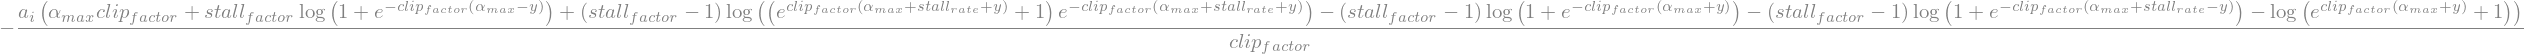

In [5]:
from sympy.abc import y
def ramp(x,corner,sharpness):
    return 1/sharpness*sym.ln(1+sym.exp(sharpness*(x+corner)))

def make_cl(x,stall_angle,stall_factor,c_l_0,sharpness):
    c_l = ramp(x,stall_angle,sharpness)
    c_l -= ramp(x,-stall_angle,sharpness)*stall_factor
    c_l += ramp(x,-(stall_angle+p.stall_rate),sharpness)*(stall_factor-1)
    c_l += ramp(-x,-(stall_angle),sharpness)*(stall_factor-1)
    c_l -= ramp(-x,-(stall_angle+p.stall_rate),sharpness)*(stall_factor-1)
    c_l -= stall_angle
    c_l *= c_l_0
    return c_l

c_l_func = lambda x: make_cl(x,p.alpha_max,p.stall_factor,p.a_i,p.clip_factor)
sym.simplify(make_cl(y,p.alpha_max,p.stall_factor,p.a_i,p.clip_factor))

In [6]:
# Main Inner Wing Aero Forces 
wing_AeroForces = ef.AeroForce.PerUnitSpan(p,wing_flexural_frame_inner,p.a_i,
                               alphadot = 0 if isinstance(tau_0,int) else tau_0.diff(me.dynamicsymbols._t),
                               M_thetadot = p.M_thetadot,
                               e = p.e_0,
                               w_g = 0,
                               root_alpha = p.alpha_r,
                                delta_alpha = tau_0,
                               alpha_zero = 0,
                               stall_angle = p.alpha_max,
                               c = p.c,
                                V = p.V,
                               c_d_max = p.c_dmax,
                               linear = True,
                                z_inverted=False,
                               unsteady=True,
                               c_l_func = lambda x: c_l_func(x))

# split Main Wing into segments
forces = []
for i in range(main_inner_panels):
    seg_width = p.s_1/main_inner_panels
    yi = seg_width/2 + i*seg_width
    forces.append(wing_AeroForces.subs({p.y_0:yi,p.a_i:p.a[i]})*seg_width)
    
Q = sym.Matrix([0]*p.qs)
for f in forces:
    Q += f.Q()

In [7]:
# Main Outer Wing Aero Forces
tau = tau_0+tau_1
wing_AeroForces = ef.AeroForce.PerUnitSpan(p,wing_flexural_frame_outer,p.a_i,
                               alphadot = 0 if isinstance(tau,int) else tau.diff(me.dynamicsymbols._t),
                               M_thetadot = p.M_thetadot,
                               e = p.e_0,
                               w_g = 0,
                               root_alpha = p.alpha_r,
                                delta_alpha = tau,
                               alpha_zero = 0,
                               stall_angle = p.alpha_max,
                               c = p.c,
                                V = p.V,
                               c_d_max = p.c_dmax,
                               linear = True,
                                z_inverted=False,
                               unsteady=True,
                               c_l_func = lambda x: c_l_func(x))

# split Main Wing into segments
forces = []
for i in range(main_outer_panels):
    seg_width = (p.s_i-p.s_1)/main_outer_panels
    yi = p.s_1 + seg_width/2 + i*seg_width
    forces.append(wing_AeroForces.subs({p.y_0:yi,p.a_i:p.a[i]})*seg_width)
    
for f in forces:
    Q += f.Q()
wing_AeroForces = ef.ExternalForce(Q)

In [8]:
# BodyJacobian = sym.simplify(ef.AeroForce._trigsimp(fwt_aero_frame.BodyJacobian(p.q)))
BodyJacobian = fwt_aero_frame.BodyJacobian(p.q)
C_L = p.a_i
alphadot = p.alphadot_1
M_thetadot = p.M_thetadot
e = 0
w_g = 0
root_alpha = p.alpha_1
delta_alpha = 0
alpha_zero = 0
stall_angle = p.alpha_max
c = p.c
V = p.V
c_d_max = p.c_dmax
linear = True
z_inverted=False
unsteady=True,
fwt_c_l_func = lambda x: c_l_func(x)+p.beta_t*p.beta_a*p.a_i
# fwt_c_l_func = lambda x: p.a_i*x+p.beta_t*p.beta_a*p.a_i
fwt_c_m_func = lambda x: p.beta_t*p.beta_m*p.a_i

dAlpha = ef.AeroForce.get_dAlpha(p,BodyJacobian,alphadot,alpha_zero, root_alpha, delta_alpha, w_g,V,c,z_inverted,unsteady)
F_n = ef.AeroForce.get_F_n(p,BodyJacobian,dAlpha,C_L,alpha_zero, stall_angle,c_d_max,V,c,linear,fwt_c_l_func)
M_w = ef.AeroForce.get_moment(p,BodyJacobian,dAlpha,F_n,C_L,alphadot,M_thetadot,e,V,c,0,fwt_c_m_func,unsteady)
F_a = ef.AeroForce.get_apparent_mass(p,BodyJacobian,C_L)


# component effecting bending
wrench_lift = sym.Matrix([0,0,-F_n,0,M_w,0]) if z_inverted else sym.Matrix([0,0,F_n,0,M_w,0])
Q_L = BodyJacobian.T*wrench_lift
fwt_AeroForces_perUnit = ef.AeroForce(Q_L,dAlpha)

# component effecting torsion
Transform = hinge_frame.R_y(tip_twist)
fwt_aeroTorque = ef.BodyForce(p,Transform,simplify=False,My = M_w*sym.cos(p.q[-1]))

In [9]:
# split FWT into segments
forces = []

# aero_mom_arm_offset = lambda x: yi#*sym.cos(p.Lambda)-p.c/(4*sym.cos(p.Lambda))
#first complete inner part without tab
seg_width = (p.s_f-p.s_t)/(fwt_panels-tab_panels)

for i in range(fwt_panels-tab_panels):
    yi = seg_width/2 + i*seg_width
    forces.append(fwt_AeroForces_perUnit.subs({p.y_1:yi,p.a_i:p.a[i+main_panels],p.beta_t:0})*seg_width)
    forces.append(fwt_aeroTorque.subs({p.y_1:yi,p.a_i:p.a[i+main_panels],p.beta_t:0})*seg_width)
    
# second complete part of wing with wingtip
ys = p.s_f-p.s_t
seg_width = p.s_t/tab_panels
for i in range(tab_panels):
    yi = ys + seg_width/2 + i*seg_width
    idx = main_panels + fwt_panels - tab_panels + i
    forces.append(fwt_AeroForces_perUnit.subs({p.y_1:yi,p.a_i:p.a[idx]})*seg_width)
    forces.append(fwt_aeroTorque.subs({p.y_1:yi,p.a_i:p.a[idx]})*seg_width)
    
# convert forces into matrix form
Q = sym.Matrix([0]*p.qs)
for f in forces:
    Q += f.Q()
fwt_AeroForces = ef.ExternalForce(Q)

In [10]:
%%time
#Create Composite force
CompositeForce = ef.CompositeForce([wing_AeroForces,fwt_AeroForces])
# Create the SYmbolic Model
sm = ma.SymbolicModel.FromElementsAndForces(p,[wing_mass_ele_inner,wing_mass_ele_outer,beam_mass_ele,beam2_mass_ele,fwt_ele,hinge_spring],CompositeForce)
# sm = ma.SymbolicModel.FromElementsAndForces(p,[wing_stiffness_ele,fwt_ele,mass_ele],CompositeForce)

0
1
2
3
4
5
Wall time: 27min 25s


In [11]:
t = me.dynamicsymbols._t
# expression for dihedral angle at the end of the inner wing
d_z_s0 = (z_0+z_1).diff(p.y_0).subs({p.y_0:p.s_i,p.x_0:0})
d_d_z_s0 = d_z_s0.diff(t)

# dummy function for dihedral angle at the end of the inner wing
dummy = sym.Function('d')(t)

# get expression for AoA on the FWT with fold angle
fwt_aoa = mf.GetAoA(p.alpha_r+tip_twist,0,p.Lambda,p.q[-1]-dummy,dummy)
d_fwt_aoa = fwt_aoa.diff(t)
# sub in place holder term for the dihedral angle and derivative with time 
d_fwt_aoa = d_fwt_aoa.subs({dummy.diff(t):p.mu_d,dummy:p.mu})
fwt_aoa = fwt_aoa.subs({dummy:p.mu})

In [12]:
# sub in expersions for AoA
sm = sm.subs({p.alpha_1:fwt_aoa,p.alphadot_1:d_fwt_aoa})

In [13]:
# export to matlab
sm.to_matlab_file(p,'C:/Git/scitech2022_post_flutter/+model/')

In [14]:
sm_lin = sm.subs({sym.sin(p.q[-1]):p.q[-1],sym.cos(p.q[-1]):1})

In [15]:
sm_lin.to_matlab_file(p,'C:/Git/scitech2022_post_flutter/+model_lin/')

In [16]:
# make files in matlab to get teh diherdral angle at the end of the innenr wing
file_dir ='C:/Git/scitech2022_post_flutter/+model/'
func_name = 'd_z_s0'
with open(file_dir+f"{func_name}.m",'w') as file:
    file.write(sm._gen_octave(d_z_s0,p,func_name))
    
func_name = 'd_d_z_s0'
with open(file_dir+f"{func_name}.m",'w') as file:
    file.write(sm._gen_octave(d_d_z_s0,p,func_name))

In [17]:
# make function to plot wings in matlab
main_wing_inner_surf = wing_frame_inner.Transform_point([0,0,0])
main_wing_outer_surf = wing_frame_outer.Transform_point([0,0,0])
fwt_surf = fwt_frame.Transform_point([0,0,0])
tau_inner = tau_0
tau_outer = tau_0 + tau_1


func_name = 'main_wing_inner_surf'
with open(file_dir+f"{func_name}.m",'w') as file:
    file.write(sm._gen_octave(main_wing_inner_surf,p,func_name))
    
func_name = 'main_wing_outer_surf'
with open(file_dir+f"{func_name}.m",'w') as file:
    file.write(sm._gen_octave(main_wing_outer_surf,p,func_name))
    
func_name = 'fwt_surf'
with open(file_dir+f"{func_name}.m",'w') as file:
    file.write(sm._gen_octave(fwt_surf,p,func_name))
    
func_name = 'tau_inner'
with open(file_dir+f"{func_name}.m",'w') as file:
    file.write(sm._gen_octave(tau_inner,p,func_name))
    
func_name = 'tau_outer'
with open(file_dir+f"{func_name}.m",'w') as file:
    file.write(sm._gen_octave(tau_outer,p,func_name))

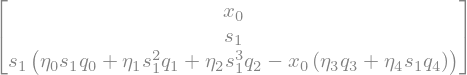

In [18]:
main_wing_inner_surf.subs({p.y_0:p.s_1})

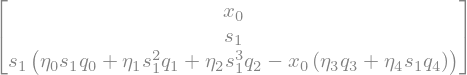

In [19]:
main_wing_outer_surf.subs({p.y_0:p.s_1})

In [20]:
from time import time, ctime
def gen_octave(expr,func_name):  
    symbols = sorted([s.name for s in expr.free_symbols], key=lambda L: (L.lower(), L))
    print(symbols)
    # split expr into groups
    replacments, exprs = sym.cse(expr,symbols=(sym.Symbol(f'rep_{i}')for i in range(10000)))
    if isinstance(expr,tuple):
        expr = tuple(exprs)
    elif isinstance(expr,list):
        expr = exprs
    else:
        expr = exprs[0]      

    group_string = '%% create common groups\n\t'
    for variable, expression in replacments:
        group_string +=f'{variable} = {sym.printing.octave.octave_code(expression)};\n\t'

    # convert to octave string and covert states to vector form
    out = '%% create output \n\tout = ' + sym.printing.octave.octave_code(expr)

    # make the file pretty...
    out = out.replace(',',',...\n\t\t').replace(';',';...\n\t\t')

    file_sig = f'%{func_name.upper()} Auto-generated function from moyra\n\t'
    file_sig += f'%\n\t'
    file_sig += f'%\tCreated at : {ctime(time())} \n\t'
    file_sig += f'%\tCreated with : moyra https://pypi.org/project/moyra/\n\t'
    file_sig += f'%\n\t'

    # wrap output in octave function signature
    signature = f'function out = {func_name}('
    for s in symbols:
        signature +=f'{s},'
    signature = signature[:-1]+')\n\t'
    octave_string = signature + file_sig  + group_string + out + ';\nend'
    return octave_string

In [21]:
## functions to get geometric AoA on Wingtip
file_dir ='C:/Git/scitech2022_post_flutter/+model/'
func_name = 'fwt_aoa'
with open(file_dir+f"{func_name}.m",'w') as file:
    file.write(gen_octave(fwt_aoa,func_name))
func_name = 'd_fwt_aoa'
with open(file_dir+f"{func_name}.m",'w') as file:
    file.write(gen_octave(d_fwt_aoa,func_name))

['alpha_r', 'eta_3', 'eta_4', 'eta_6', 'Lambda', 'mu', 's_1', 's_i', 't']
['alpha_r', 'eta_3', 'eta_4', 'eta_6', 'Lambda', 'mu', 'mu_d', 's_1', 's_i', 't']


In [22]:
## functions to get C_l curve
func_name = 'C_l'
with open(file_dir+f"{func_name}.m",'w') as file:
    file.write(gen_octave(c_l_func(p.alpha_1),func_name))

['a_i', 'alpha_1', 'alpha_max', 'clip_factor', 'stall_factor', 'stall_rate']


In [23]:
## functions to get interesting outputs
hinge_z = z_0.subs({p.y_0:p.s_i,p.x_0:0})
hinge_twist = tau_0.subs({p.y_0:p.s_i,p.x_0:0})
hinge_dihedral = d_z_s0
fold_angle = p.q[-1] - hinge_dihedral
local_aoa_root = dAlpha.subs({p.alpha_1:fwt_aoa,p.y_1:0})
local_aoa_mid = dAlpha.subs({p.alpha_1:fwt_aoa,p.y_1:p.s_f/2})
local_aoa_tip = dAlpha.subs({p.alpha_1:fwt_aoa,p.y_1:p.s_f})

In [24]:
file_dir ='C:/Git/scitech2022_post_flutter/+model/'
func_names = ('hinge_z','hinge_twist','hinge_dihedral','fold_angle','local_aoa_root','local_aoa_mid','local_aoa_tip')
funcs = (hinge_z,hinge_twist,hinge_dihedral,fold_angle,local_aoa_root,local_aoa_mid,local_aoa_tip)
for fun,nam in zip(funcs,func_names):
    with open(file_dir+f"{nam}.m",'w') as file:
        file.write(sm._gen_octave(fun,p,nam))

In [25]:
import moyra.printing as moyp
test = sm._gen_octave(sm.f[0],p,'test')
test.find('Deriv')